
**Install requirements**

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

!rm -rf "./DANN"
!rm -rf "./PACS"

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import ImageFolder

from PIL import Image
from tqdm import tqdm

import numpy as np
from google.colab import output

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

output.clear()

**Set Arguments, Define Data Preprocessing, Prepare Datasets, DataLoader and Network**

In [0]:
util = Utility()

DEVICE, NUM_CLASSES, NUM_DOMAINS, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY, IMAGE_SIZE = util.load_default_parameters()
 
train_transform, test_transform = util.load_default_transformations()

# Clone github repository with data
if not os.path.isdir('./PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git
  !mv 'Homework3-PACS' 'PACS'

# Clone personal github repository with DANN model class
if not os.path.isdir('./DANN'):
  !git clone https://github.com/cpeluso/HW3-Deep-Domain-Adaptation.git
  !mv 'HW3-Deep-Domain-Adaptation' 'DANN'

DATA_DIR = [
  "PACS/PACS/art_painting",
  "PACS/PACS/cartoon",
  "PACS/PACS/photo",
  "PACS/PACS/sketch"
]

# Photo
train_dataset = ImageFolder(DATA_DIR[2], transform = train_transform) 
dataloader_source = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

# Art Painting
test_dataset = ImageFolder(DATA_DIR[0], transform = test_transform) 
dataloader_target = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Cartoon
cartoon_dataset = ImageFolder(DATA_DIR[1]) 
dataloader_target_cartoon = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Sketch
sketch_dataset = ImageFolder(DATA_DIR[3]) 
dataloader_target_sketch = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Training**

In [0]:
target_set = iter(dataloader_target)
def sample_target(step, n_batches):
    global target_set
    if step % n_batches == 0:
        target_set = iter(dataloader_target)
    return target_set.next()


**Train**

<Figure size 432x288 with 0 Axes>

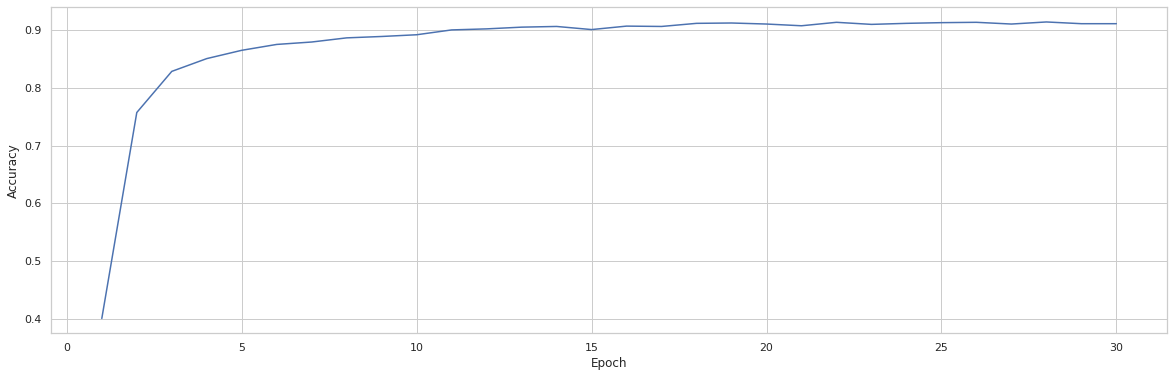

<Figure size 432x288 with 0 Axes>

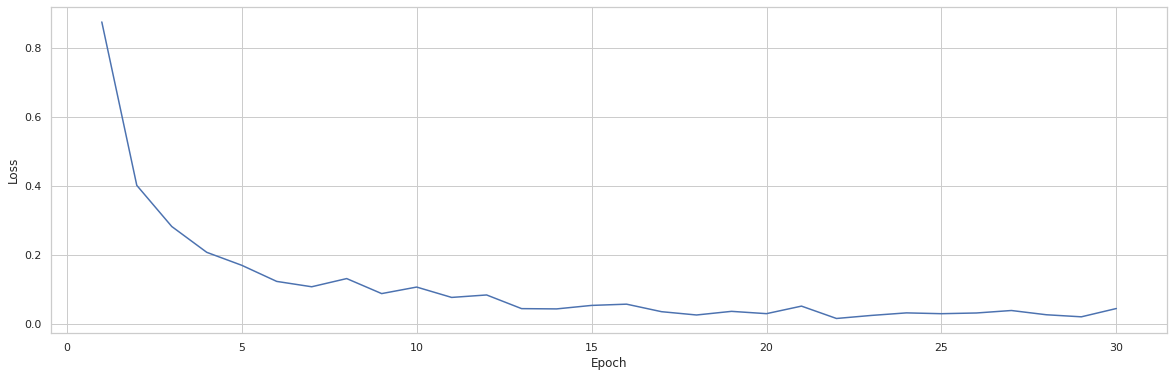

In [7]:
from DANN.DANN import RandomNetworkWithReverseGrad
dann = RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True)

# Apply weights of pretrained AlexNet also to the domain classifier branch
for classifier_layer, dann_classifier_layer in zip(dann.classifier, dann.dann_classifier):
  if type(classifier_layer) is torch.nn.modules.linear.Linear:
    dann_classifier_layer.weight.data = classifier_layer.weight.data
    dann_classifier_layer.bias.data = classifier_layer.bias.data

# Change number of outputs of last fully connected layers of classifier and domain classifier
dann.classifier[6] = nn.Linear(4096, NUM_CLASSES)
dann.dann_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()

parameters_to_optimize = dann.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


output.clear()

dann = dann.to(DEVICE) 
cudnn.benchmark
current_step = 0

classifier_accuracies = []
classifier_losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  
  print("Epoch " + str(epoch+1))
  
  running_corrects = 0

  for index, (source_images, labels) in enumerate(dataloader_source):

    dann.train()

    source = source_images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()

    # Forward source data to the classifier branch of the network
    classifier_output = dann(source)
    classifier_loss = loss_classifier(classifier_output, labels)
    classifier_loss.backward()

    # Get predictions
    _, preds = torch.max(classifier_output.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    optimizer.step()

  scheduler.step() 

  # Calculate Accuracy
  accuracy = running_corrects / float(len(train_dataset))
  
  print("Classifier accuracy: ", str(accuracy))
  print("Classifier loss: ", str(classifier_loss.item()))

  classifier_accuracies.append( (epoch + 1, accuracy) )
  classifier_losses.append( (epoch + 1, classifier_loss.item()) )

output.clear()
util.plot_accuracies(classifier_accuracies)
util.plot_losses(classifier_losses)

In [8]:
# Set Network to evaluation mode
dann.train(False) 

running_corrects = 0
for images, labels in tqdm(dataloader_target):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = dann(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('\nTest Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Test Accuracy: 0.4521484375


<Figure size 432x288 with 0 Axes>

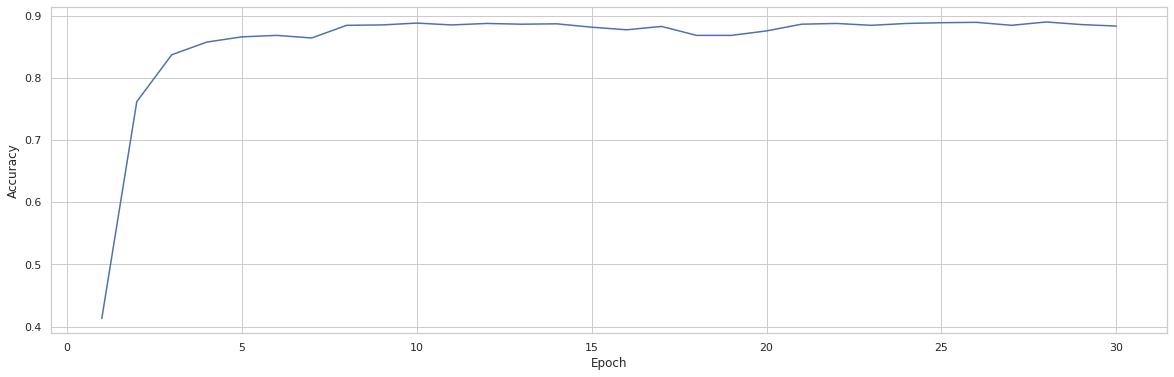

<Figure size 432x288 with 0 Axes>

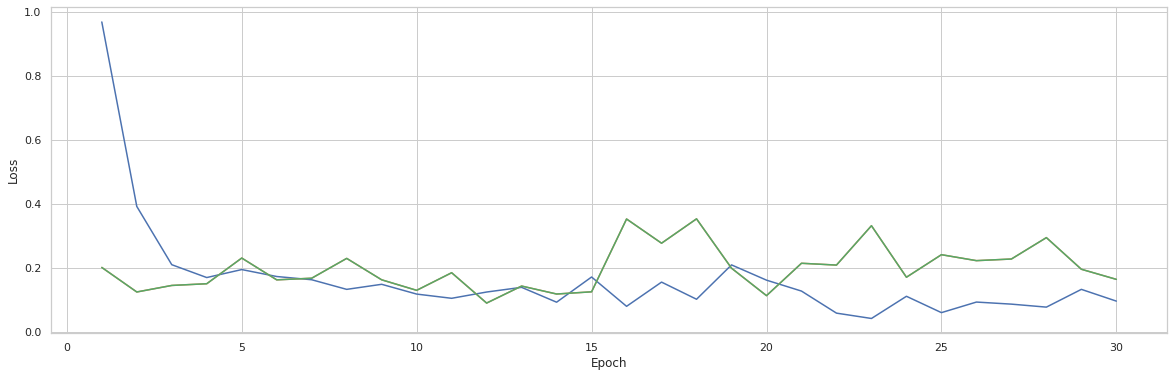

In [10]:
from DANN.DANN import RandomNetworkWithReverseGrad
dann = RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True)

# Apply weights of pretrained AlexNet also to the domain classifier branch
for classifier_layer, dann_classifier_layer in zip(dann.classifier, dann.dann_classifier):
  if type(classifier_layer) is torch.nn.modules.linear.Linear:
    dann_classifier_layer.weight.data = classifier_layer.weight.data
    dann_classifier_layer.bias.data = classifier_layer.bias.data

# Change number of outputs of last fully connected layers of classifier and domain classifier
dann.classifier[6] = nn.Linear(4096, NUM_CLASSES)
dann.dann_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()

parameters_to_optimize = dann.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

output.clear()

discriminator_source_labels = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo
discriminator_target_labels = torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Art Painting
discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)

LAMBDA=0.5
already_recomputed_short_discriminator_target_labels = False

dann = dann.to(DEVICE) 
cudnn.benchmark
current_step = 0

classifier_accuracies = []
classifier_losses = []
discriminator_source_losses = []
discriminator_target_losses = []
short_discriminator_target_labels = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  
  print("Epoch " + str(epoch+1))
  
  running_corrects = 0

  for index, (source_images, labels) in enumerate(dataloader_source):

    dann.train()

    target_images, target_set = sample_target(current_step, BATCH_SIZE)

    source = source_images.to(DEVICE)
    target = target_images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()

    # Forward source data to the classifier branch of the network
    classifier_output = dann(source)
    classifier_loss = loss_classifier(classifier_output, labels)
    classifier_loss.backward()

    # Get predictions
    _, preds = torch.max(classifier_output.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    # Forward source data to the discriminator branch of the network
    discriminator_output_source = dann(source, LAMBDA)
    discriminator_loss_source = loss_discriminator(discriminator_output_source, discriminator_source_labels)
    discriminator_loss_source.backward()

    # Forward target data to the discriminator branch of the network
    discriminator_output_target = dann(target, LAMBDA)
    if BATCH_SIZE != len(discriminator_output_target):

      # Define short_discriminator_target_labels if not defined yet
      short_discriminator_target_labels = torch.zeros(len(discriminator_output_target), dtype = torch.long).to(DEVICE) if len(short_discriminator_target_labels) else short_discriminator_target_labels
    
      discriminator_loss_target = loss_discriminator(discriminator_output_target, short_discriminator_target_labels)
   
    else:
      
      discriminator_loss_target = loss_discriminator(discriminator_output_target, discriminator_target_labels)

    discriminator_loss_target.backward()

    optimizer.step()

  scheduler.step() 

  # Calculate Accuracy
  accuracy = running_corrects / float(len(train_dataset))
  
  print("Classifier accuracy: ", str(accuracy))
  print("Classifier loss: ", str(classifier_loss.item()))
  print("Discriminator (source) loss: ", str(discriminator_loss_source.item()))
  print("Discriminator (target) loss: ", str(discriminator_loss_target.item()))

  classifier_accuracies.append( (epoch + 1, accuracy) )
  classifier_losses.append( (epoch + 1, classifier_loss.item()) )
  discriminator_source_losses.append( (epoch + 1, discriminator_loss_source.item()) )
  discriminator_target_losses.append( (epoch + 1, discriminator_loss_target.item()) )

output.clear()
util.plot_accuracies(classifier_accuracies)
util.plot_losses(classifier_losses, discriminator_source_losses, discriminator_target_losses)

In [13]:
# Set Network to evaluation mode
dann.train(False) 

running_corrects = 0
for images, labels in tqdm(dataloader_target):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = dann(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('\nTest Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Test Accuracy: 0.455078125


In [0]:
discriminator_source_labels = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo
discriminator_target_labels = torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Art Painting
discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)

LAMBDA=0.5
already_recomputed_short_discriminator_target_labels = False

dann = dann.to(DEVICE) 
cudnn.benchmark
current_step = 0

classifier_accuracies = []
classifier_losses = []
discriminator_source_losses = []
discriminator_target_losses = []
short_discriminator_target_labels = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  
  print("Epoch " + str(epoch+1))
  
  running_corrects = 0

  for index, (source_images, labels) in enumerate(dataloader_source):

    dann.train()

    target_images, target_set = sample_target(current_step, BATCH_SIZE)

    source = source_images.to(DEVICE)
    target = target_images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()

    # Forward source data to the classifier branch of the network
    classifier_output = dann(source)
    classifier_loss = loss_classifier(classifier_output, labels)
    classifier_loss.backward()

    # Get predictions
    _, preds = torch.max(classifier_output.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    # Forward source data to the discriminator branch of the network
    discriminator_output_source = dann(source, LAMBDA)
    discriminator_loss_source = loss_discriminator(discriminator_output_source, discriminator_source_labels)
    discriminator_loss_source.backward()

    # Forward target data to the discriminator branch of the network
    discriminator_output_target = dann(target, LAMBDA)
    if BATCH_SIZE != len(discriminator_output_target):

      # Define short_discriminator_target_labels if not defined yet
      short_discriminator_target_labels = torch.zeros(len(discriminator_output_target), dtype = torch.long).to(DEVICE) if len(short_discriminator_target_labels) else short_discriminator_target_labels
    
      discriminator_loss_target = loss_discriminator(discriminator_output_target, short_discriminator_target_labels)
   
    else:
      
      discriminator_loss_target = loss_discriminator(discriminator_output_target, discriminator_target_labels)

    discriminator_loss_target.backward()

    optimizer.step()

  scheduler.step() 

  # Calculate Accuracy
  accuracy = running_corrects / float(len(train_dataset))
  
  print("Classifier accuracy: ", str(accuracy))
  print("Classifier loss: ", str(classifier_loss.item()))
  print("Discriminator (source) loss: ", str(discriminator_loss_source.item()))
  print("Discriminator (target) loss: ", str(discriminator_loss_target.item()))

  classifier_accuracies.append( (epoch + 1, accuracy) )
  classifier_losses.append( (epoch + 1, classifier_loss.item()) )
  discriminator_source_losses.append( (epoch + 1, discriminator_loss_source.item()) )
  discriminator_target_losses.append( (epoch + 1, discriminator_loss_target.item()) )

output.clear()
util.plot_accuracies(classifier_accuracies)
util.plot_losses(classifier_losses, discriminator_source_losses, discriminator_target_losses)

In [0]:
class Utility():
  def __init__(self):
    pass

  def load_default_parameters(self):
    default_DEVICE = 'cuda'
    default_NUM_CLASSES = 7
    default_NUM_DOMAINS = 2 
    default_BATCH_SIZE = 256 
    default_LR = 0.001           
    default_MOMENTUM = 0.9      
    default_WEIGHT_DECAY = 5e-5  
    default_NUM_EPOCHS = 30
    default_STEP_SIZE = 20   
    default_GAMMA = 0.1    
    default_LOG_FREQUENCY = 10
    default_IMAGE_SIZE = 224
    return (default_DEVICE, default_NUM_CLASSES, default_NUM_DOMAINS, default_BATCH_SIZE, default_LR, default_MOMENTUM, default_WEIGHT_DECAY, default_NUM_EPOCHS, default_STEP_SIZE, default_GAMMA, default_LOG_FREQUENCY, default_IMAGE_SIZE)
    pass

  def load_default_transformations(self):
    return (transforms.Compose([
      transforms.Resize(256),      
      transforms.CenterCrop(224),                            
      transforms.ToTensor(), 
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ]),
    transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
    ]))
    pass

  def plot_losses(self, classifier_losses = [], discriminator_source_losses = [], discriminator_target_losses = []):

    plt.figure()  
    sns.set(style = "whitegrid")
    fig, ax = plt.subplots(figsize=(20, 6))

    if classifier_losses != []:
      classifier_loss_df = pd.DataFrame(classifier_losses)
      classifier_loss_df = classifier_loss_df.astype(float)
      classifier_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=classifier_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")


    if discriminator_source_losses != []:
      discriminator_source_loss_df = pd.DataFrame(discriminator_source_losses)
      discriminator_source_loss_df = discriminator_source_loss_df.astype(float)
      discriminator_source_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=discriminator_source_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")
    
    if discriminator_source_losses != []:
      discriminator_target_loss_df = pd.DataFrame(discriminator_source_losses)
      discriminator_target_loss_df = discriminator_target_loss_df.astype(float)
      discriminator_target_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=discriminator_target_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")

    pass

  def plot_accuracies(self, classifier_accuracies = []):
    classifier_accuracies_df = pd.DataFrame(classifier_accuracies)
    classifier_accuracies_df = classifier_accuracies_df.astype(float)
    classifier_accuracies_df.columns=['Epoch','Accuracy']

    plt.figure()  
    sns.set(style = "whitegrid")
    fig, ax = plt.subplots(figsize=(20, 6))

    sns.lineplot(x='Epoch',y='Accuracy',data=classifier_accuracies_df, markers=True, dashes=False,  ax = ax)
    pass